In [1]:
import pandas as pd
from TrajectoryClusteringAnalysis.tca import TCA

## Load data

In [2]:
df = pd.read_csv('../data/dataframe_test.csv')
df.head()

,id,month,care_status,sex,age,education,wealth,distance_clinic
0,3,0.0,D,1.0,1.0,2.0,2.0,1.0
1,3,1.0,D,1.0,1.0,2.0,2.0,1.0
2,3,2.0,D,1.0,1.0,2.0,2.0,1.0
3,3,3.0,D,1.0,1.0,2.0,2.0,1.0
4,3,4.0,D,1.0,1.0,2.0,2.0,1.0


## Preprocessing data
### convert data from long format to wide format

In [15]:
# Sélectionner les colonnes pertinentes pour l'analyse
selected_cols = df[['id', 'month', 'care_status']]
# Créer un tableau croisé des données en format large
#       -> Chaque individu est sur une ligne.
#       -> Les mesures dans le temps (Temps1, Temps2, Temps3) sont des colonnes distinctes.
pivoted_data = selected_cols.pivot(index='id', columns='month', values='care_status')
pivoted_data['id'] = pivoted_data.index
pivoted_data = pivoted_data[['id'] + [col for col in pivoted_data.columns if col != 'id']]
# Renommer les colonnes avec un préfixe "month_"
pivoted_data.columns = ['id'] + ['month_' + str(int(col)+1) for col in pivoted_data.columns[1:]]
# Sélectionner un échantillon aléatoire de 10% des données
pivoted_data_random_sample = pivoted_data.sample(frac=0.1, random_state=42).reset_index(drop=True)
pivoted_data_random_sample.head()

,id,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,month_42,month_43,month_44,month_45,month_46,month_47,month_48,month_49,month_50,month_51
0,4971,D,D,D,D,D,D,D,D,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7484,D,D,D,D,D,D,D,D,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1252,D,D,D,D,D,D,D,D,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9004,D,D,D,D,D,D,D,D,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6229,D,T,T,D,D,D,D,D,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## pakage initialization

In [4]:
tca = TCA(data=pivoted_data_random_sample,
              id='id',
              alphabet=['D', 'C', 'T', 'S'],
              states=["diagnostiqué", "en soins", "sous traitement", "inf. contrôlée"])

INFO:root:TCA object initialized successfully


Dataset :
data shape:  (293, 52)
state coding:
   alphabet            label  label encoded
0        D     diagnostiqué              1
1        C         en soins              2
2        T  sous traitement              3
3        S   inf. contrôlée              4


## Distance levenshtein

In [5]:
distance_matrix = tca.compute_distance_matrix(metric='levenshtein', substitution_cost_matrix=None)
print("distance matrix :\n",distance_matrix)

INFO:root:Calculating distance matrix using metric: levenshtein...
100%|██████████| 293/293 [00:00<00:00, 641.64it/s]
INFO:root:Time taken for computation: 0.46 seconds


distance matrix :
 [[ 0.  2. 10. ...  4.  8. 13.]
 [ 2.  0. 10. ...  2.  6. 11.]
 [10. 10.  0. ... 10. 13. 15.]
 ...
 [ 4.  2. 10. ...  0.  4.  9.]
 [ 8.  6. 13. ...  4.  0.  5.]
 [13. 11. 15. ...  9.  5.  0.]]


INFO:root:Computing the linkage matrix using method: ward...
INFO:root:Linkage matrix computed successfully


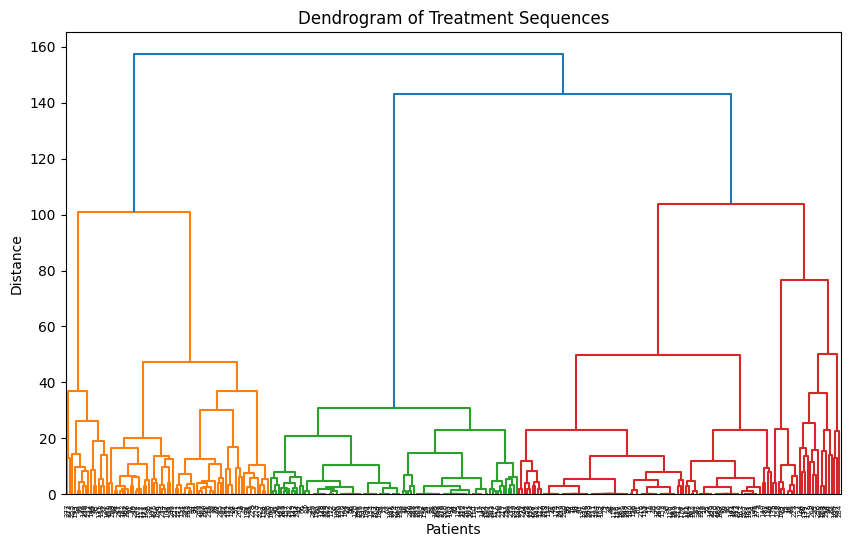

In [6]:
linkage_matrix = tca.hierarchical_clustering(distance_matrix)
tca.plot_dendrogram(linkage_matrix)

### plot heatmap with distance lev

c:\Users\ndiaga.dieng\Documents\TrajectoryClusteringAnalysis\venv\lib\site-packages\TrajectoryClusteringAnalysis\plotting.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.clustermap(data.drop(id_col, axis=1).replace(label_to_encoded),


<Figure size 800x800 with 0 Axes>

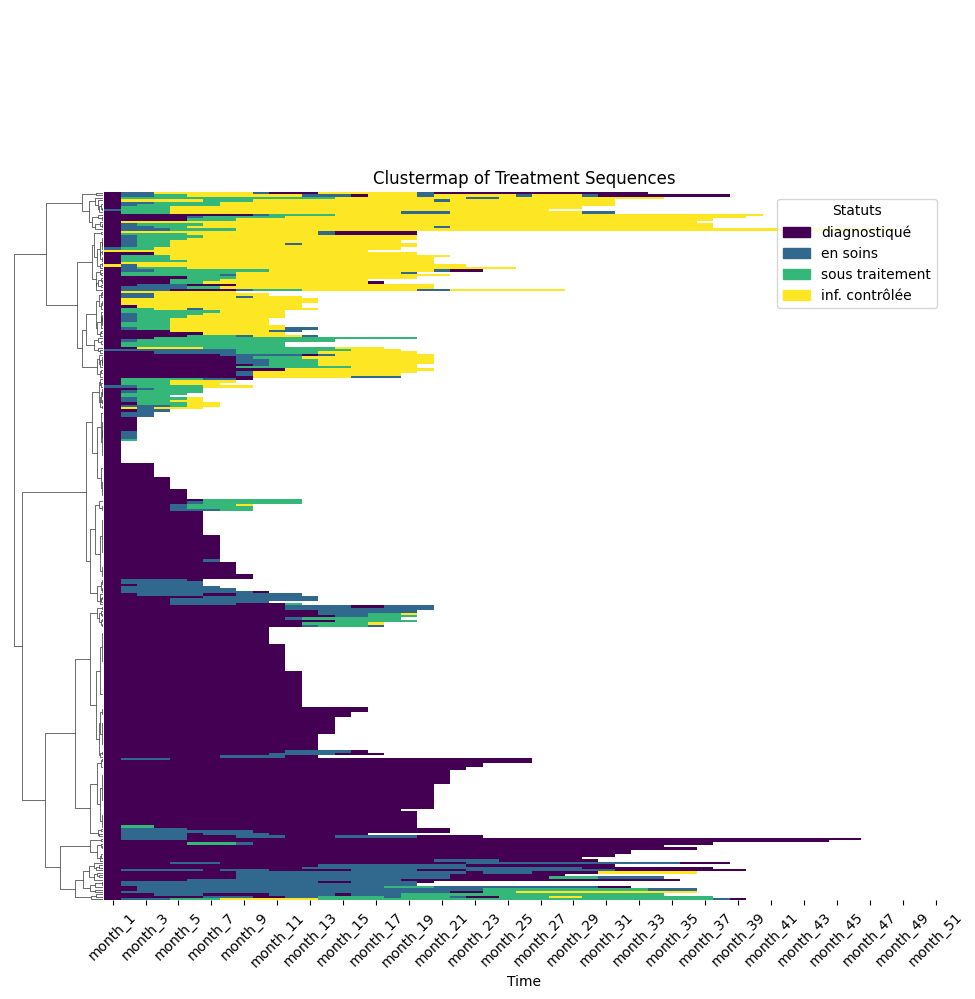

In [7]:
tca.plot_clustermap(linkage_matrix)

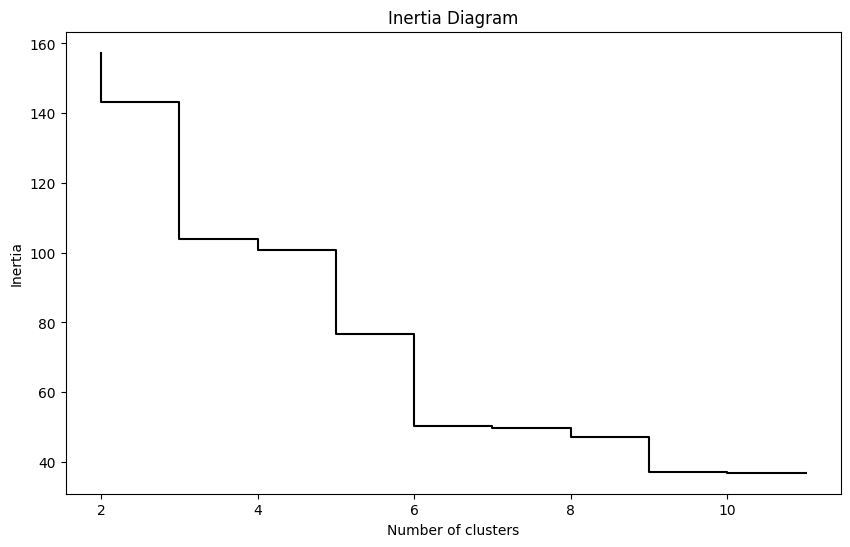

In [8]:
tca.plot_inertia(linkage_matrix)

c:\Users\ndiaga.dieng\Documents\TrajectoryClusteringAnalysis\venv\lib\site-packages\TrajectoryClusteringAnalysis\plotting.py:109: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(cluster_df[1].drop(id_col, axis=1).replace(label_to_encoded), cmap=colors, cbar=False, ax=ax, yticklabels=False)
c:\Users\ndiaga.dieng\Documents\TrajectoryClusteringAnalysis\venv\lib\site-packages\TrajectoryClusteringAnalysis\plotting.py:109: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(cluster_df[1].drop(id_col, axis=1).replace(labe

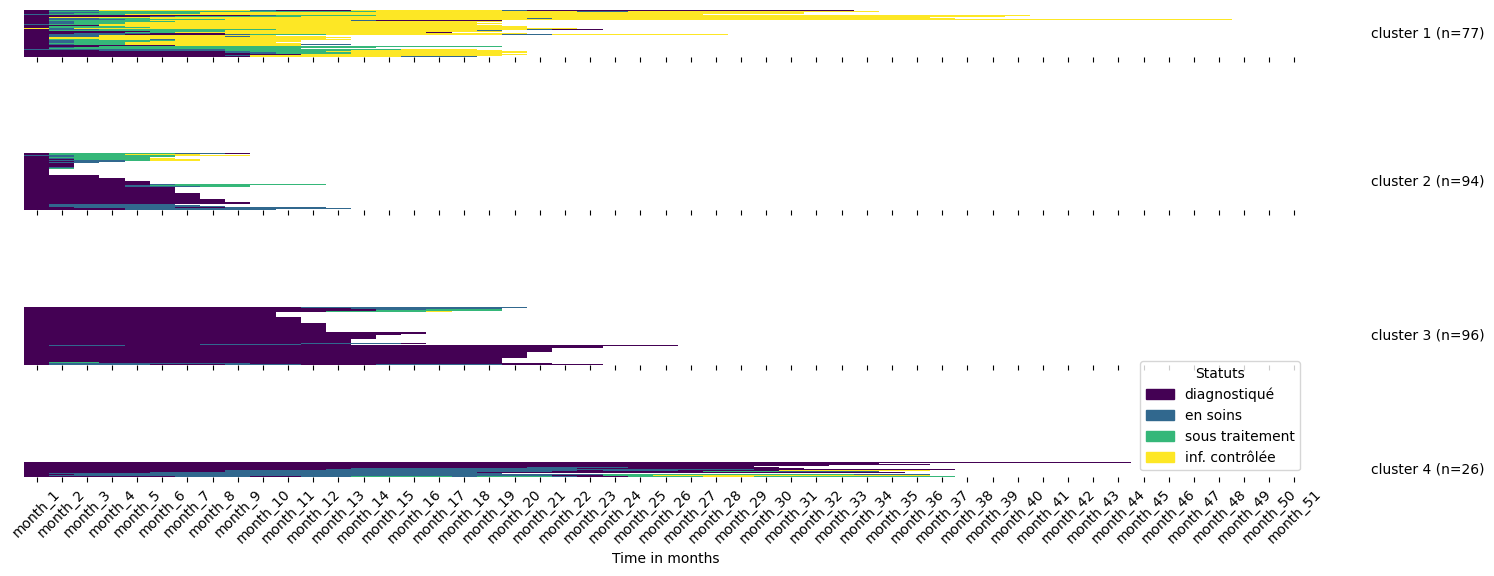

In [9]:
clusters = tca.assign_clusters(linkage_matrix, num_clusters=4)
    
tca.plot_cluster_heatmaps(clusters, sorted=False)

In [10]:
from sklearn.metrics import silhouette_score
silhouette_score(distance_matrix, clusters)

0.34843325442893625

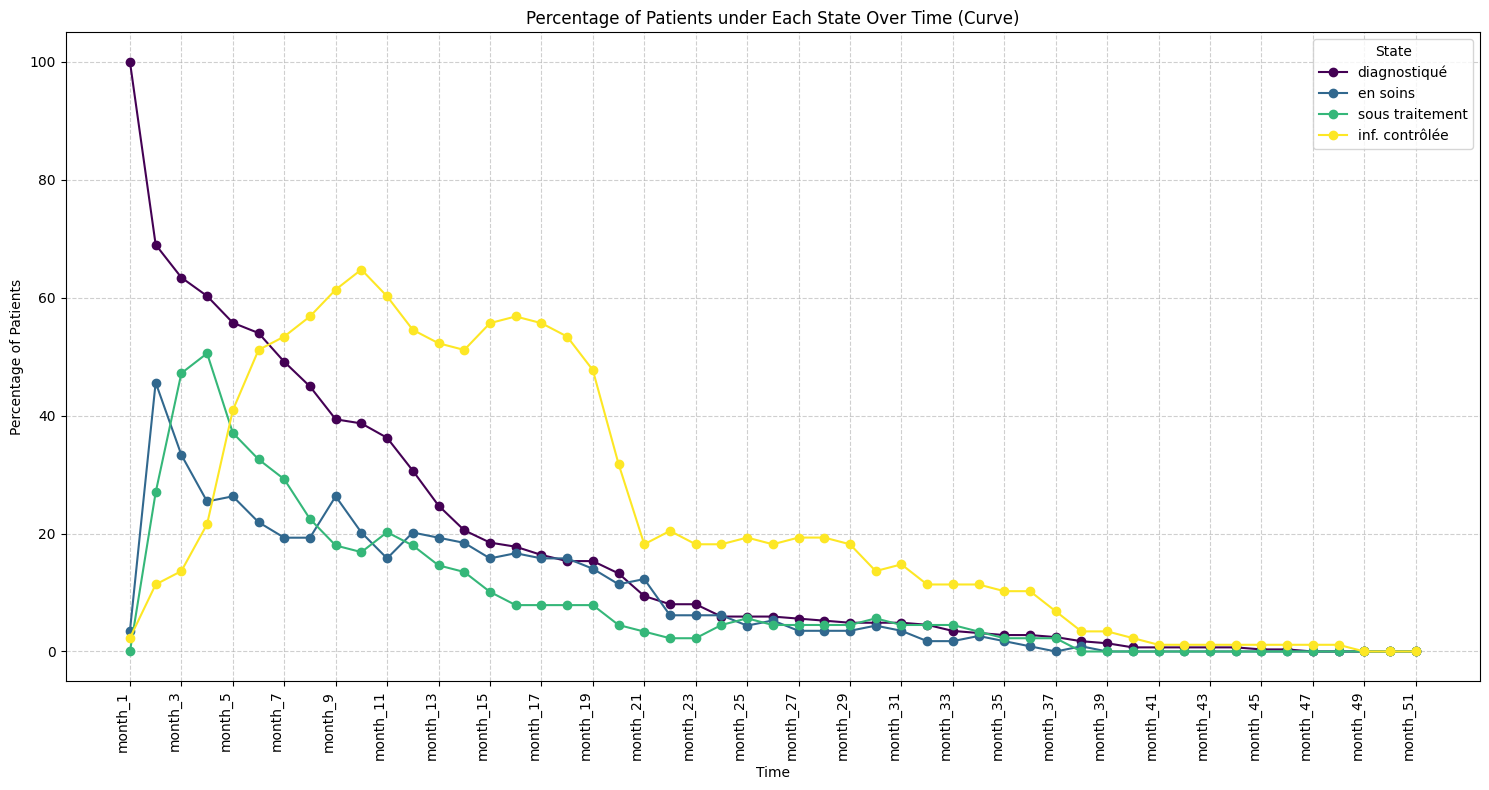

In [11]:
tca.plot_treatment_percentage()

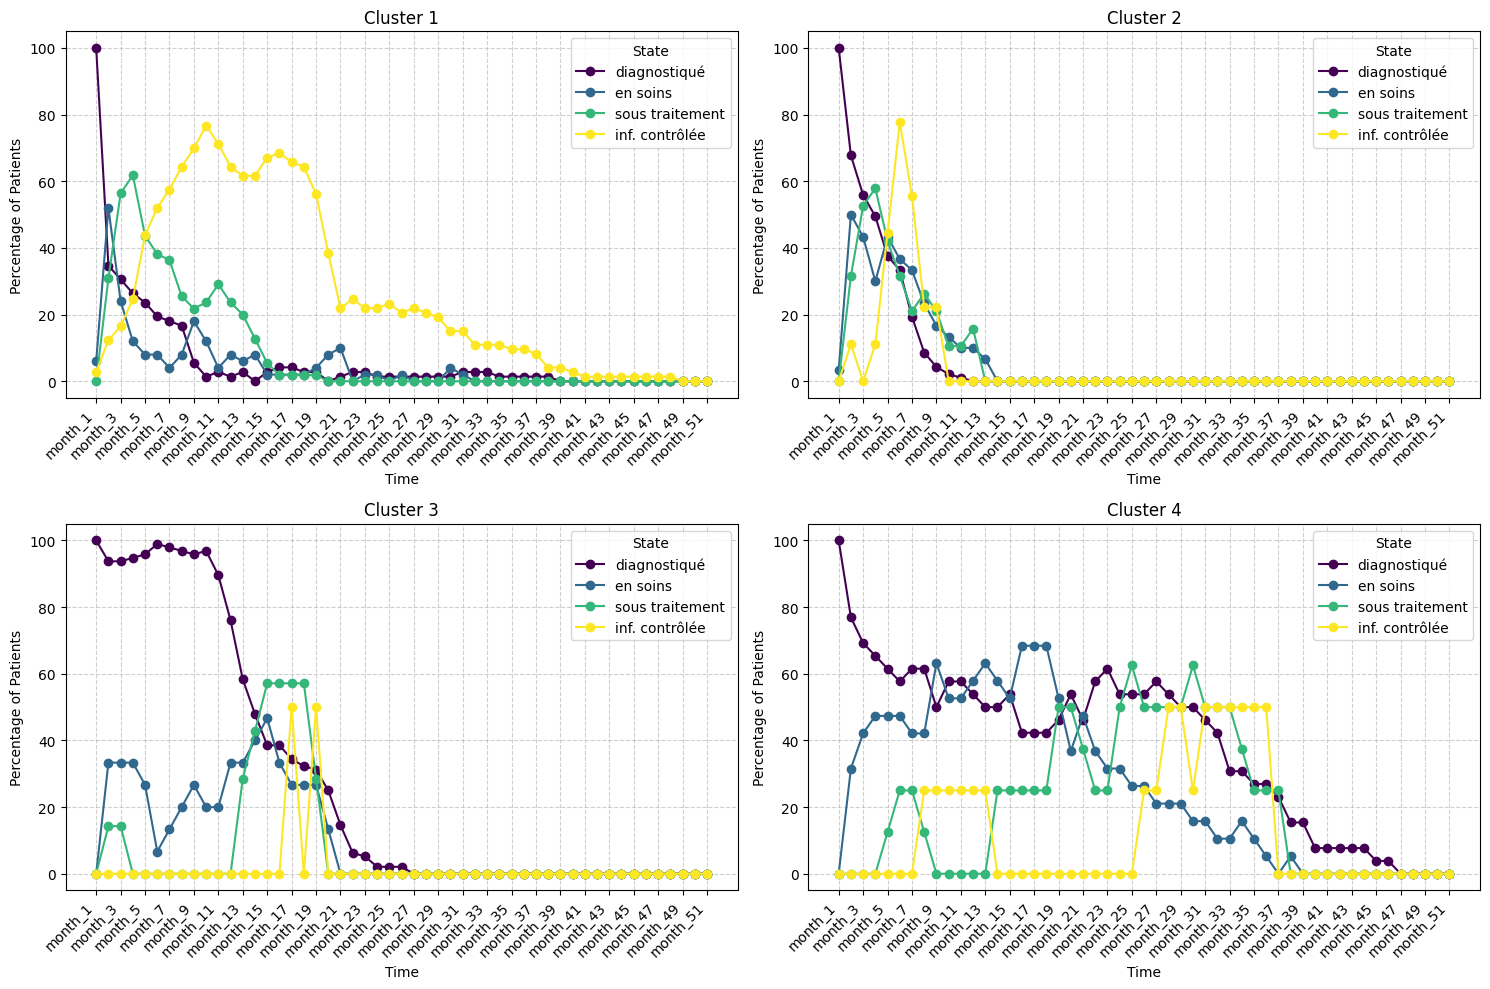

In [12]:
tca.plot_treatment_percentage(clusters=clusters)

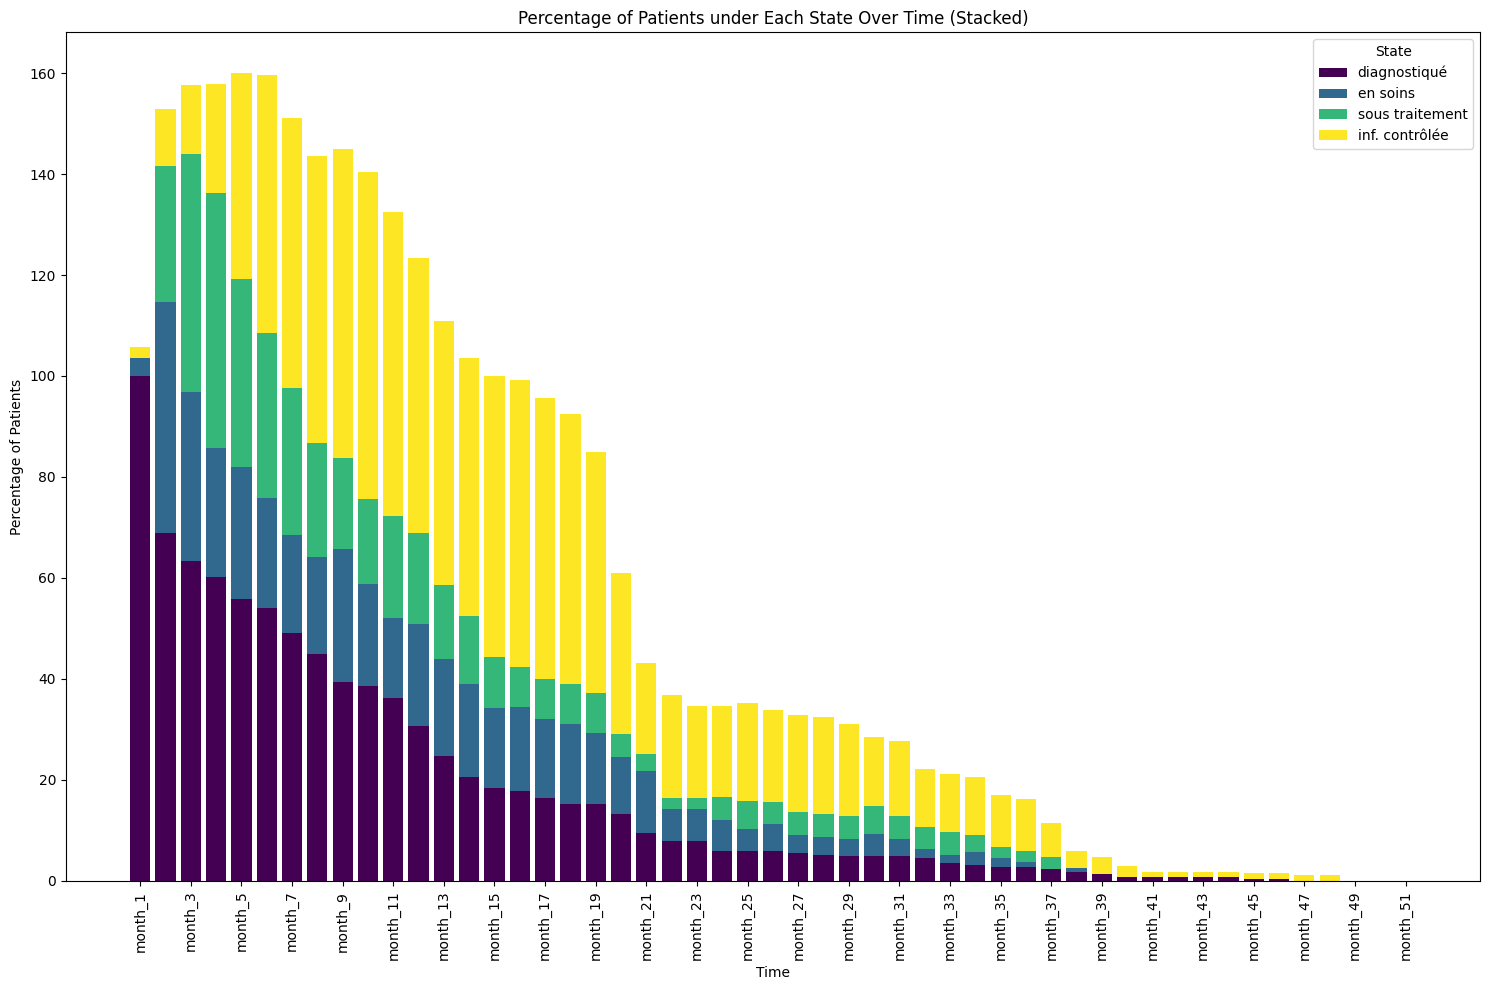

In [13]:

tca.bar_treatment_percentage()

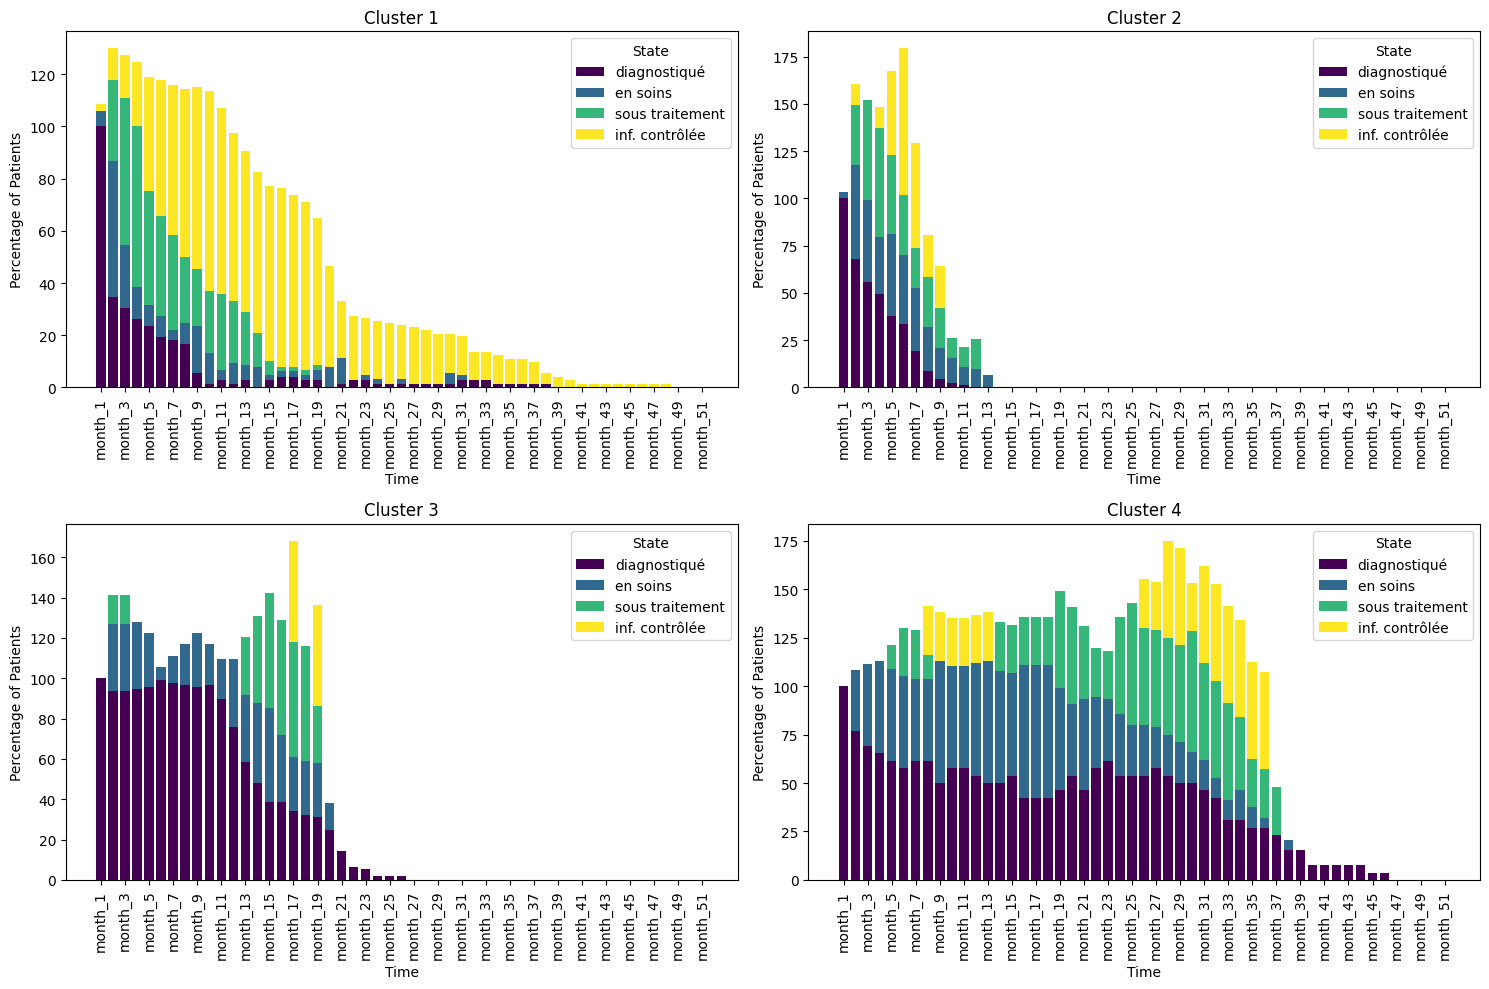

In [14]:
tca.bar_treatment_percentage(clusters=clusters)